Name: Purusharth Malik

Registration No.: 2348542

# **Implement BERT for token classification in NER tasks.**

**Installing Necessary Libraries**

In [1]:
%pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
    

In [2]:
%pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=f578bb553a955891681c10e78eb2bb493998d8f0ca9cf2cd845408da45908e40
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


**Importing Necessary Libraries**

In [3]:
from datasets import load_dataset
from transformers import AutoTokenizer,Trainer,AutoModelForTokenClassification,TrainingArguments,DataCollatorForTokenClassification
import numpy as np
from datasets import load_metric
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification

**Loading the Dataset**

We’ll use the datasets library to load a dataset. For this example, we'll use the CoNLL-2003 dataset.**

In [4]:
dataset = load_dataset("conll2003")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for conll2003 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conll2003.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

**Data Preprocessing**

Tokenize the input texts and align the labels with the tokens.

In [7]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [8]:
train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
eval_dataset = tokenized_datasets["validation"].shuffle(seed=42).select(range(100))

**Defining the Model **
Load the pre-trained BERT model for token classification.

In [6]:
model_name = "distilbert-base-cased"
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(dataset["train"].features["ner_tags"].feature.names))
tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

**Setting Up Training Arguments**

Define the training arguments using the TrainingArguments class.

In [15]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    fp16=True)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


**Creating Data Collator**

This will handle dynamic padding.

In [16]:
data_collator = DataCollatorForTokenClassification(tokenizer)

**Computing Metrics **

Define a function to compute metrics.

In [22]:
metric = load_metric("seqeval")

# Define label names
label_list = dataset["train"].features["ner_tags"].feature.names

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_labels = [[label_list[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

**Initializing Trainer**

Use the Trainer class to initialize the training process.

In [23]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

**Training and Evaluating**

Finally, train and evaluate the model.

In [24]:
trainer.train()
trainer.evaluate()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.066666,0.868132,0.892655,0.880223,0.981711
2,No log,0.072235,0.886364,0.881356,0.883853,0.980405
3,No log,0.076274,0.898305,0.898305,0.898305,0.983018
4,0.013800,0.072955,0.888889,0.903955,0.896359,0.983671
5,0.013800,0.074324,0.898876,0.903955,0.901408,0.983671


{'eval_loss': 0.07432430237531662,
 'eval_precision': 0.898876404494382,
 'eval_recall': 0.903954802259887,
 'eval_f1': 0.9014084507042253,
 'eval_accuracy': 0.983670803396473,
 'eval_runtime': 0.1868,
 'eval_samples_per_second': 535.304,
 'eval_steps_per_second': 69.59,
 'epoch': 5.0}

**Saving Trained Model**


In [25]:
model.save_pretrained("./my_ner_model")
tokenizer.save_pretrained("./my_ner_model")

('./my_ner_model/tokenizer_config.json',
 './my_ner_model/special_tokens_map.json',
 './my_ner_model/vocab.txt',
 './my_ner_model/added_tokens.json',
 './my_ner_model/tokenizer.json')

**Testing the Model**

In [28]:
model_path = "./my_ner_model"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForTokenClassification.from_pretrained(model_path)

ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

test_text = "Hugging Face Inc. is a company based in New York City. Its headquarters are in DUMBO, therefore very close to the Manhattan Bridge."

ner_results = ner_pipeline(test_text)

print("Named Entities:")
for entity in ner_results:
    print(f"Entity: {entity['word']}")
    print(f"Label: {entity['entity_group']}")
    print(f"Score: {entity['score']:.4f}")
    print("---")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Named Entities:
Entity: Hu
Label: LABEL_3
Score: 0.9644
---
Entity: ##gging
Label: LABEL_0
Score: 0.9446
---
Entity: Face Inc
Label: LABEL_4
Score: 0.9965
---
Entity: . is a company based in
Label: LABEL_0
Score: 0.9983
---
Entity: New
Label: LABEL_5
Score: 0.9969
---
Entity: York City
Label: LABEL_6
Score: 0.9944
---
Entity: . Its headquarters are in
Label: LABEL_0
Score: 0.9998
---
Entity: D
Label: LABEL_5
Score: 0.9985
---
Entity: ##UMBO
Label: LABEL_6
Score: 0.9889
---
Entity: , therefore very close to the
Label: LABEL_0
Score: 0.9999
---
Entity: Manhattan
Label: LABEL_5
Score: 0.9950
---
Entity: Bridge
Label: LABEL_6
Score: 0.9948
---
Entity: .
Label: LABEL_0
Score: 0.9998
---


Streamlit Application

In [30]:
%pip install -q groq
%pip install streamlit -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.9 MB/s eta 0:00:00


In [31]:
!wget -q -O - ipv4.icanhazip.com

34.82.194.200


In [34]:
%%writefile app.py


import streamlit as st
from transformers import pipeline

# Load the pre-trained BERT model for token classification (NER)
@st.cache_resource
def load_ner_pipeline():
    return pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english", aggregation_strategy="simple")

ner_pipeline = load_ner_pipeline()

st.title("Named Entity Recognition with BERT")
st.write("Enter some text and see the named entities identified by the BERT model.")

input_text = st.text_area("Input Text", "Hugging Face Inc. is a company based in New York City. Its headquarters are in DUMBO, therefore very close to the Manhattan Bridge.")

if st.button("Analyze"):
    if input_text:
        st.write("Processing...")
        ner_results = ner_pipeline(input_text)

        st.write("## Named Entities:")
        for entity in ner_results:
            st.write(f"**Entity:** {entity['word']}")
            st.write(f"**Label:** {entity['entity_group']}")
            st.write(f"**Score:** {entity['score']:.4f}")
            st.write("---")
    else:
        st.write("Please enter some text to analyze.")

Overwriting app.py


In [35]:
!streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.82.194.200:8501

your url is: https://beige-sloths-draw.loca.lt
2024-08-04 18:22:45.788869: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-04 18:22:45.812490: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-04 18:22:45.819961: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-04 18:22:48.047242: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
config.json: 100% 

**The App Results look like this**

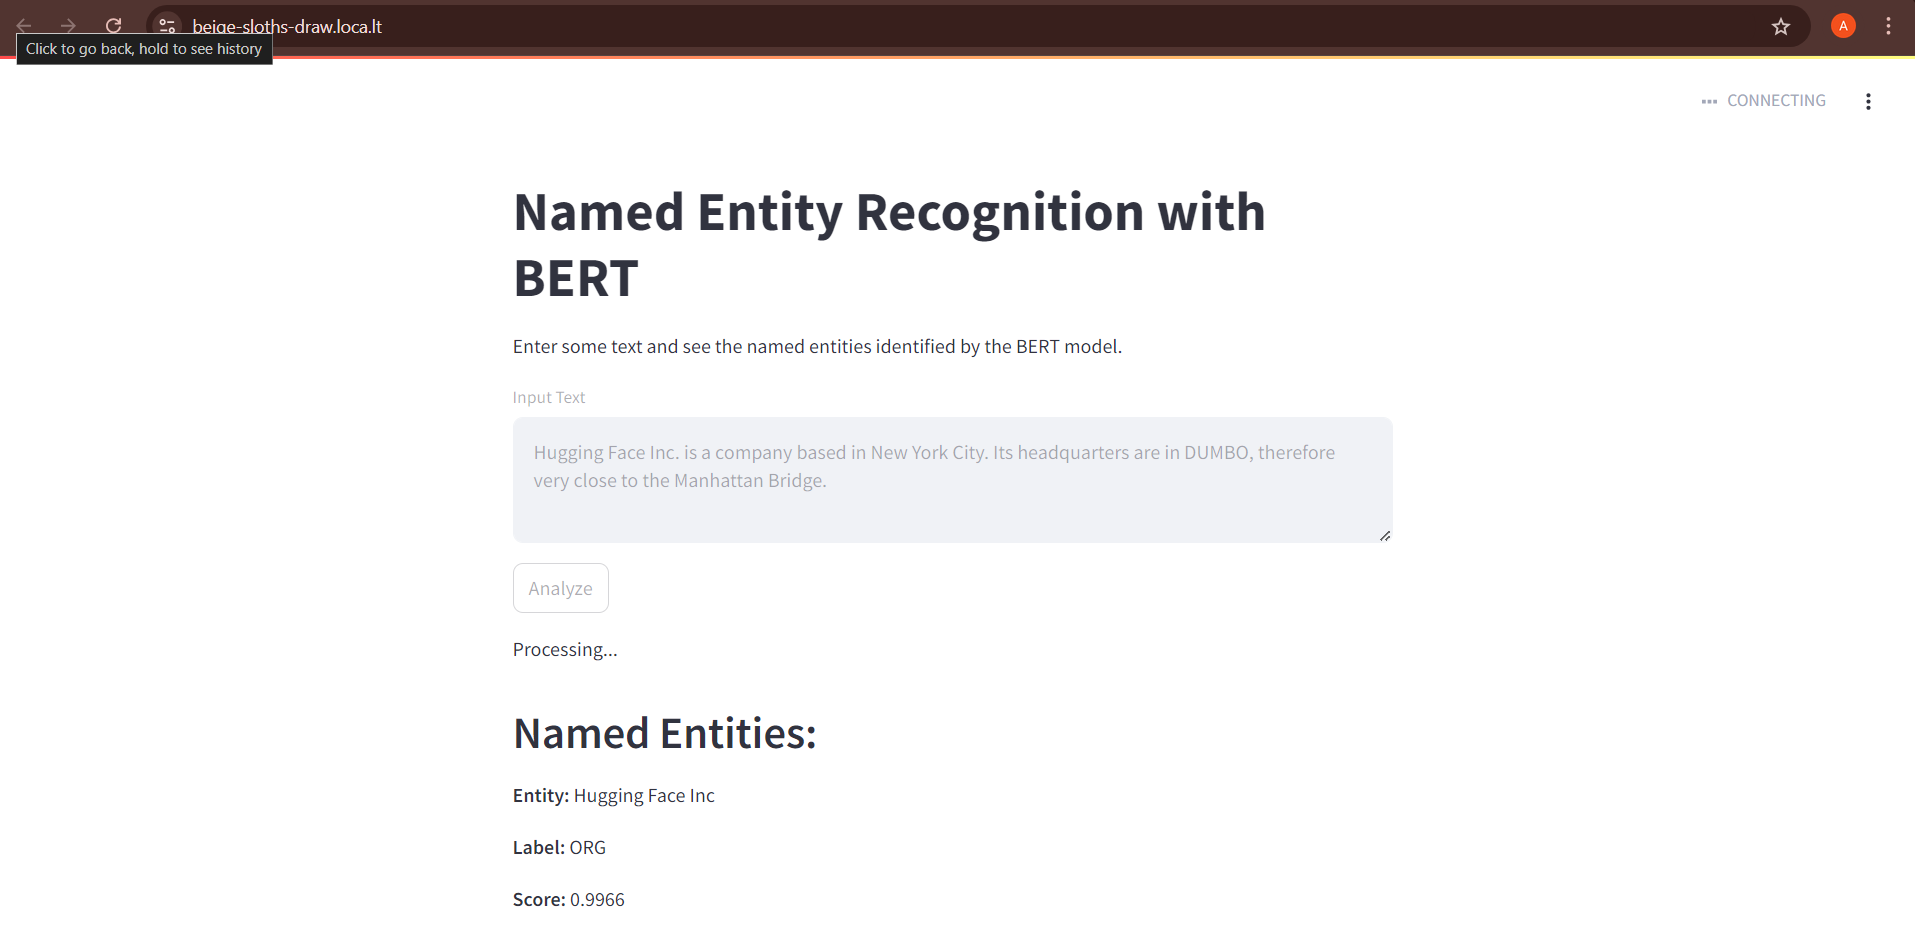

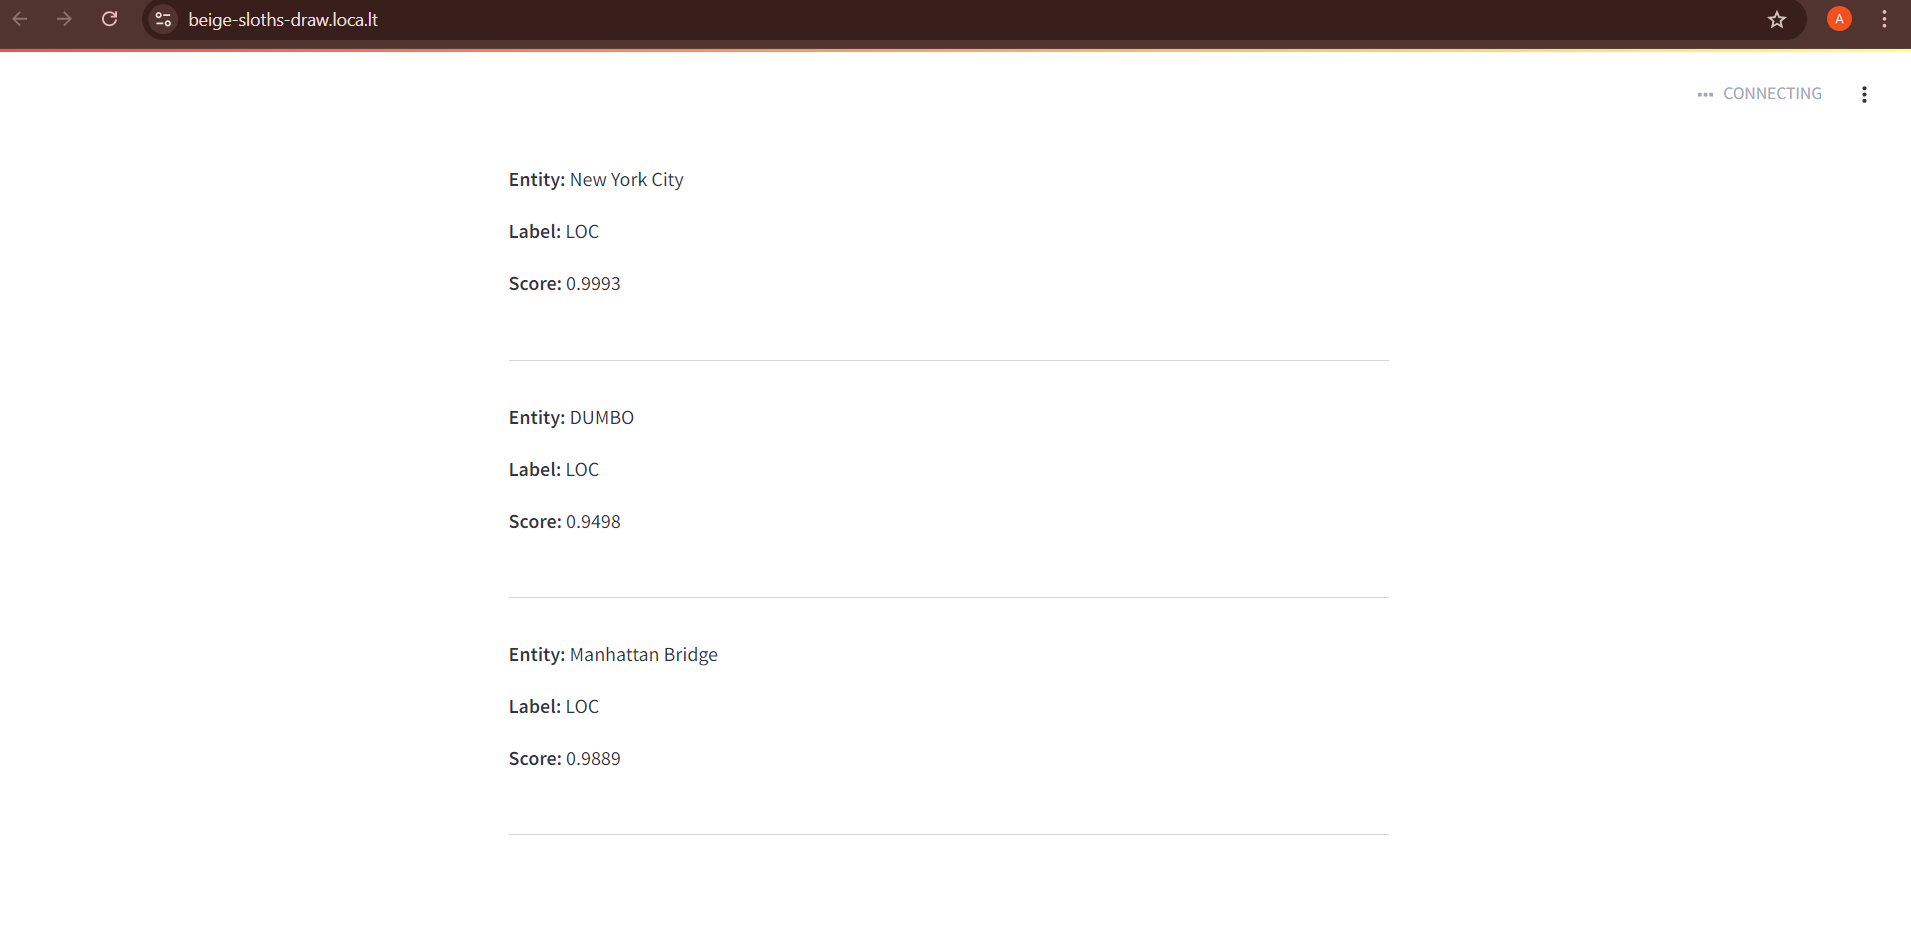